Data already found in ./camvid_data
Found 701 images / 701 masks.
Loading & resizing data...


100%|██████████| 701/701 [00:24<00:00, 28.25it/s]



--- Generating EDA Visualizations ---


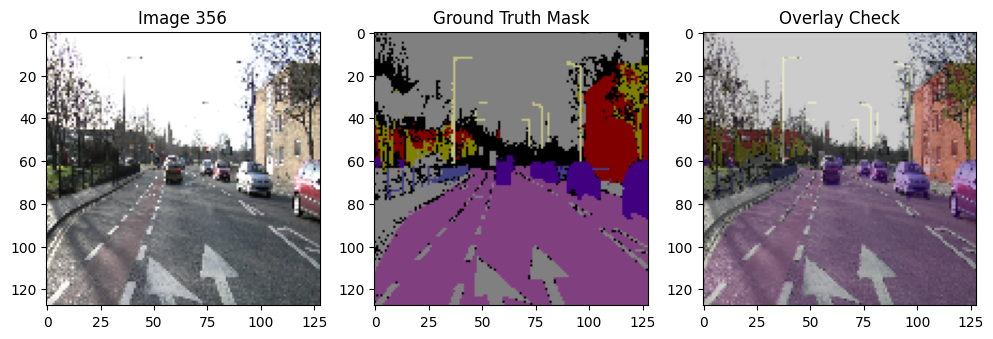

Calculating class distribution...


/tmp/ipython-input-1791124915.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=CLASS_NAMES, y=counts, palette="viridis")


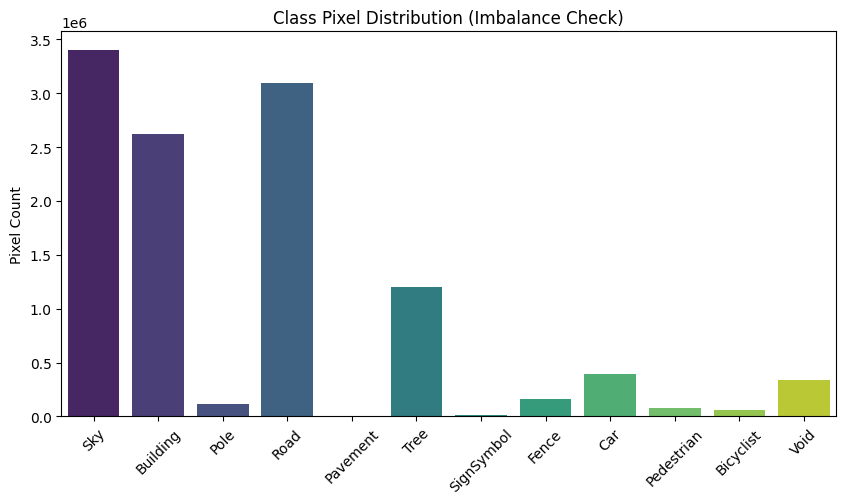

Calculating pixel intensity...


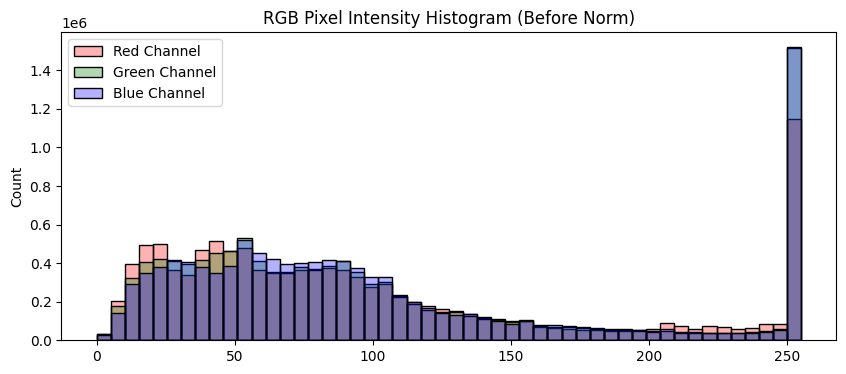


--- Starting Training ---
Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 107s 693ms/step - accuracy: 0.5280 - iou: 0.1768 - loss: 2.5625 - val_accuracy: 0.1524 - val_iou: 0.0282 - val_loss: 4.3876
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.7879 - iou: 0.3377 - loss: 1.4737 - val_accuracy: 0.1850 - val_iou: 0.0462 - val_loss: 4.2264
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - accuracy: 0.8249 - iou: 0.3963 - loss: 1.2719 - val_accuracy: 0.2441 - val_iou: 0.0604 - val_loss: 4.2047
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 263ms/step - accuracy: 0.8449 - iou: 0.4341 - loss: 1.1676 - val_accuracy: 0.3341 - val_iou: 0.0681 - val_loss: 4.3541
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.8609 - iou: 0.4720 - loss: 1.0812 - val_accuracy: 0.3266 - val_iou: 0.0624 - val_loss: 5.0472
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.8643 - iou: 0.4869 - loss: 1.0547 - val_accuracy: 0.2652 - val_iou: 0.0516 - val_loss: 5.4470
Epoch 7/30


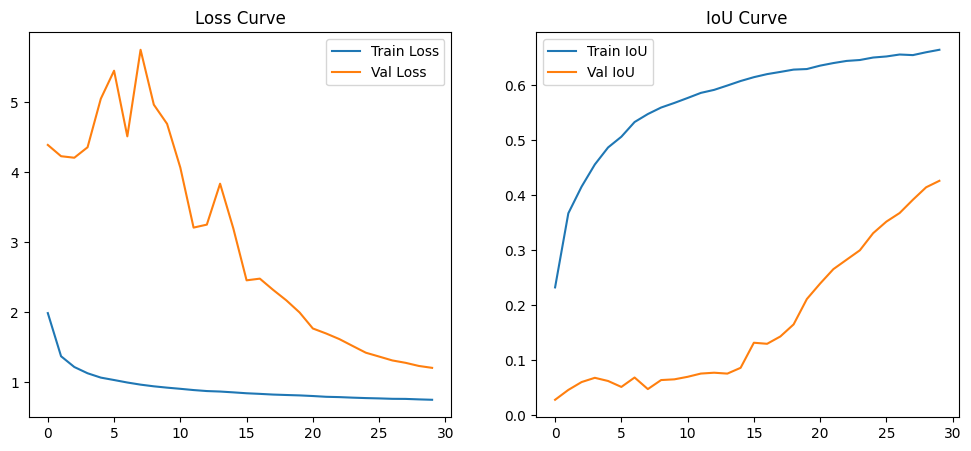

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


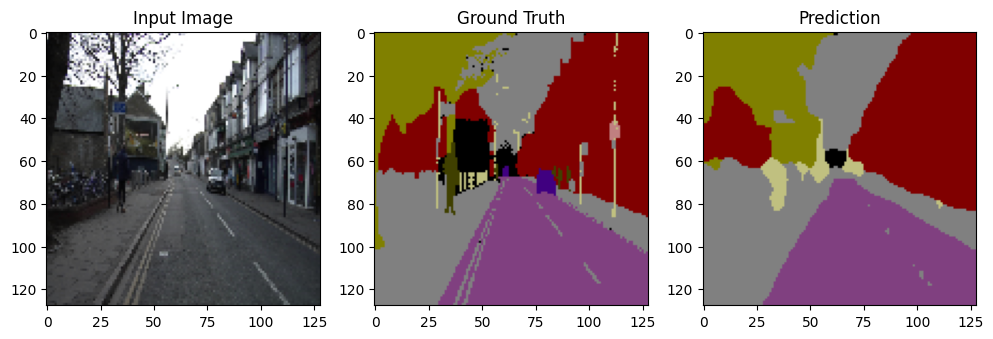

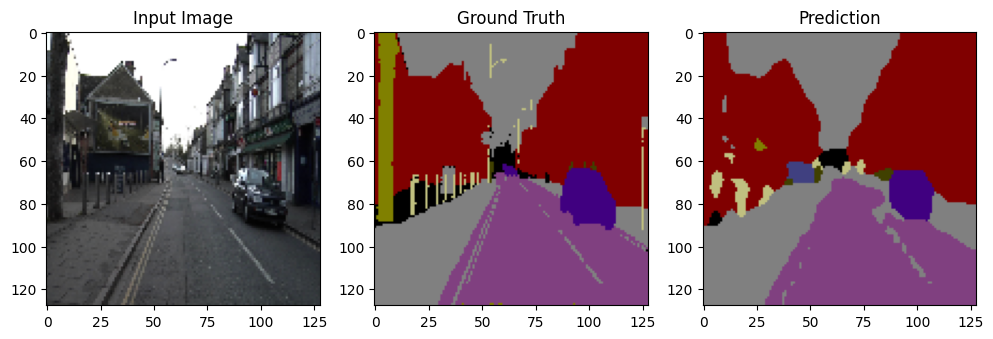

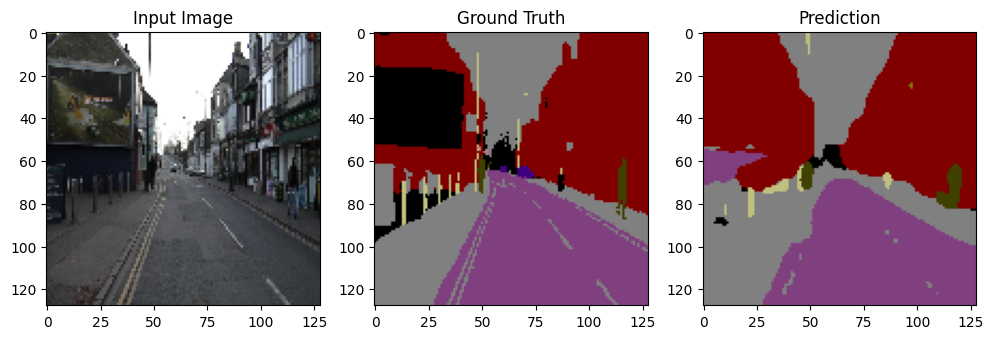

Computing Confusion Matrix on Validation Set (this may take a moment)...


100%|██████████| 9/9 [00:05<00:00,  1.50it/s]


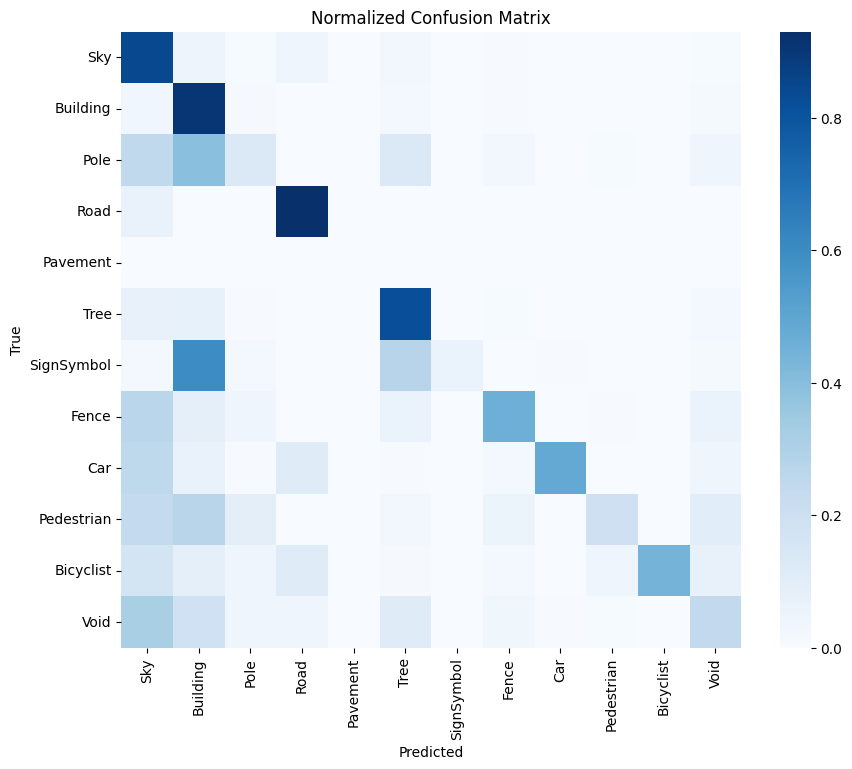

In [2]:
import os
import zipfile
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import sys # Added for sys.exit()

# ==========================================
# 1. CONFIGURATION
# ==========================================d
IMG_HEIGHT = 128
IMG_WIDTH = 128
N_CLASSES = 12
BATCH_SIZE = 16
EPOCHS = 30
SEED = 42

# CamVid Class Mapping (RGB -> ID)
CLASSES = {
    'Sky':        (128, 128, 128),
    'Building':   (128, 0, 0),
    'Pole':       (192, 192, 128),
    'Road':       (128, 64, 128),
    'Pavement':   (60, 40, 222),
    'Tree':       (128, 128, 0),
    'SignSymbol': (192, 128, 128),
    'Fence':      (64, 64, 128),
    'Car':        (64, 0, 128),
    'Pedestrian': (64, 64, 0),
    'Bicyclist':  (0, 128, 192),
    'Void':       (0, 0, 0)
}
CLASS_NAMES = list(CLASSES.keys())
# Normalized color array (0-1) for plotting (not used in this version but kept for context)
CLASS_COLORS_NORM = np.array(list(CLASSES.values()), dtype=np.float32) / 255.0
# Integer color array for mapping
CLASS_COLORS = np.array(list(CLASSES.values()), dtype=np.uint8)

# ==========================================
# 2. DATA LOADING & UTILS
# ==========================================
def find_and_unzip(extract_path="./camvid_data"):
    if os.path.exists(extract_path) and len(os.listdir(extract_path)) > 0:
        print(f"Data already found in {extract_path}")
        return extract_path
    zip_files = glob("*.zip")
    if not zip_files:
        print("FATAL: No .zip file found. Please upload CamVid.zip.")
        return None
    print(f"Unzipping {zip_files[0]}...")
    with zipfile.ZipFile(zip_files[0], 'r') as z:
        z.extractall(extract_path)
    return extract_path

def map_rgb_to_class(mask_rgb):
    # Map 3D RGB mask to 2D Class ID mask
    mask_id = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)
    for idx, color in enumerate(CLASS_COLORS):
        matches = np.all(mask_rgb == color, axis=-1)
        mask_id[matches] = idx
    return mask_id

def load_data(root_dir, img_size=(128, 128)):
    # Find files
    all_pngs = sorted(glob(os.path.join(root_dir, '**', '*.png'), recursive=True))
    img_paths = [f for f in all_pngs if '_L' not in f and 'label' not in f.lower()]
    mask_paths = [f for f in all_pngs if '_L' in f or 'label' in f.lower()]

    # Ensure sorting matches pairs
    img_paths.sort()
    mask_paths.sort()

    print(f"Found {len(img_paths)} images / {len(mask_paths)} masks.")

    X, Y = [], []
    print("Loading & resizing data...")
    for i in tqdm(range(len(img_paths))):
        # Image
        img = cv2.cvtColor(cv2.imread(img_paths[i]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        # Mask
        mask = cv2.cvtColor(cv2.imread(mask_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

        X.append(img)
        Y.append(map_rgb_to_class(mask))

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)

# Colorize helper for visualization
def colorize_mask(mask_2d):
    h, w = mask_2d.shape
    img = np.zeros((h, w, 3), dtype=np.uint8)
    for id in range(N_CLASSES):
        img[mask_2d == id] = CLASS_COLORS[id]
    return img

# ==========================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================
def perform_eda(X, Y):
    print("\n--- Generating EDA Visualizations ---")

    # 1. Sample Image + Mask Overlay
    idx = random.randint(0, len(X)-1)
    sample_img = X[idx].astype(np.uint8)
    sample_mask_color = colorize_mask(Y[idx])

    overlay = cv2.addWeighted(sample_img, 0.6, sample_mask_color, 0.4, 0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(sample_img); plt.title(f"Image {idx}")
    plt.subplot(1, 3, 2); plt.imshow(sample_mask_color); plt.title("Ground Truth Mask")
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay Check")
    plt.show()

    # 2. Class Distribution
    print("Calculating class distribution...")
    flat_masks = Y.flatten()
    counts = np.bincount(flat_masks, minlength=N_CLASSES)
    total = counts.sum()

    plt.figure(figsize=(10, 5))
    sns.barplot(x=CLASS_NAMES, y=counts, palette="viridis")
    plt.xticks(rotation=45)
    plt.title("Class Pixel Distribution (Imbalance Check)")
    plt.ylabel("Pixel Count")
    plt.show()

    # 3. Pixel Intensity Histogram
    print("Calculating pixel intensity...")
    # Flatten X into (N_pixels, 3)
    flat_pixels = X.reshape(-1, 3)

    plt.figure(figsize=(10, 4))
    colors = ['red', 'green', 'blue']
    for i, color in enumerate(colors):
        sns.histplot(flat_pixels[:, i], color=color, bins=50, alpha=0.3, label=f'{color.title()} Channel')
    plt.title("RGB Pixel Intensity Histogram (Before Norm)")
    plt.legend()
    plt.show()

# ==========================================
# 4. DATA PIPELINE
# ==========================================
def create_dataset(X, Y, is_train=True):
    # Normalize X
    X_norm = X / 255.0
    # Expand Y dims
    Y_exp = np.expand_dims(Y, axis=-1)

    dataset = tf.data.Dataset.from_tensor_slices((X_norm, Y_exp))

    if is_train:
        dataset = dataset.shuffle(100)
        # Simple augmentation
        def augment(img, mask):
            if tf.random.uniform(()) > 0.5:
                img = tf.image.flip_left_right(img)
                mask = tf.image.flip_left_right(mask)
            return img, mask
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

# ==========================================
# 5. MODEL ARCHITECTURE (DeepLabV3+)
# ==========================================
def aspp_block(x, filters):
    # 1x1 Conv
    x1 = layers.Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)

    # Rates for Atrous Conv
    rates = [6, 12, 18]
    x2 = layers.Conv2D(filters, (3, 3), padding='same', dilation_rate=rates[0], use_bias=False)(x)
    x2 = layers.BatchNormalization()(x2); x2 = layers.Activation('relu')(x2)

    x3 = layers.Conv2D(filters, (3, 3), padding='same', dilation_rate=rates[1], use_bias=False)(x)
    x3 = layers.BatchNormalization()(x3); x3 = layers.Activation('relu')(x3)

    x4 = layers.Conv2D(filters, (3, 3), padding='same', dilation_rate=rates[2], use_bias=False)(x)
    x4 = layers.BatchNormalization()(x4); x4 = layers.Activation('relu')(x4)

    # Image Pooling
    dims = x.shape
    x5 = layers.GlobalAveragePooling2D()(x)
    # FIX: Reshape to (1, 1, original_channels) then apply Conv2D to reduce channels
    x5 = layers.Reshape((1, 1, x5.shape[-1]))(x5) # Reshape to (1, 1, C) where C is the channel dimension after pooling
    x5 = layers.Conv2D(filters, (1, 1), padding='same', use_bias=False)(x5)
    x5 = layers.BatchNormalization()(x5); x5 = layers.Activation('relu')(x5)
    x5 = layers.UpSampling2D(size=(dims[1], dims[2]), interpolation='bilinear')(x5)

    x = layers.Concatenate()([x1, x2, x3, x4, x5])
    x = layers.Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    return x

def build_deeplab():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Encoder
    base = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    # Get features
    feat_high = base.get_layer("conv4_block6_out").output
    feat_low = base.get_layer("conv2_block3_out").output

    # ASPP
    x = aspp_block(feat_high, 256)
    x = layers.UpSampling2D((4, 4), interpolation='bilinear')(x)

    # Decoder
    feat_low = layers.Conv2D(48, (1, 1), padding='same', use_bias=False)(feat_low)
    feat_low = layers.BatchNormalization()(feat_low)
    feat_low = layers.Activation('relu')(feat_low)

    x = layers.Concatenate()([x, feat_low])
    x = layers.Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)

    # Output
    x = layers.UpSampling2D((4, 4), interpolation='bilinear')(x)
    outputs = layers.Conv2D(N_CLASSES, (1, 1), activation='softmax')(x)

    return models.Model(inputs, outputs)

# ==========================================
# 6. METRICS & LOSS
# ==========================================
class SemanticIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Squeeze y_true from (Batch, H, W, 1) to (Batch, H, W) for MeanIoU
        y_true = tf.squeeze(y_true, axis=-1)
        # Convert predictions to sparse integers
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

def dice_ce_loss(y_true, y_pred):
    # Cross Entropy
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Dice
    y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=N_CLASSES)
    y_true_onehot = tf.squeeze(y_true_onehot, axis=3)

    num = 2. * tf.reduce_sum(y_true_onehot * y_pred, axis=[1, 2])
    den = tf.reduce_sum(y_true_onehot + y_pred, axis=[1, 2])
    dice = 1 - (num + 1e-6) / (den + 1e-6)

    return ce + tf.reduce_mean(dice)

# ==========================================
# 7. MAIN EXECUTION & TRAINING
# ==========================================
if __name__ == "__main__":
    # A. Load
    data_path = find_and_unzip()
    if not data_path: sys.exit(0)

    X_raw, Y_raw = load_data(data_path)

    # B. EDA Visualization (Requested Step)
    perform_eda(X_raw, Y_raw)

    # C. Split
    split = int(len(X_raw) * 0.8)
    X_train, Y_train = X_raw[:split], Y_raw[:split]
    X_val, Y_val = X_raw[split:], Y_raw[split:]

    # D. Prepare Datasets
    train_ds = create_dataset(X_train, Y_train, is_train=True)
    val_ds = create_dataset(X_val, Y_val, is_train=False)

    # E. Train
    model = build_deeplab()
    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss=dice_ce_loss,
        metrics=['accuracy', SemanticIoU(num_classes=N_CLASSES, name='iou')]
    )

    print("\n--- Starting Training ---")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[
            callbacks.ModelCheckpoint('camvid_best.keras', save_best_only=True, monitor='val_iou', mode='max'),
            callbacks.EarlyStopping(patience=8, monitor='val_iou', mode='max')
        ]
    )

    # ==========================================
    # 8. POST-TRAINING VISUALIZATION
    # ==========================================
    print("\n--- Generating Result Visualizations ---")

    # 1. Training Curves
    hist = history.history
    epochs = range(len(hist['loss']))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist['loss'], label='Train Loss')
    plt.plot(epochs, hist['val_loss'], label='Val Loss')
    plt.title("Loss Curve"); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist['iou'], label='Train IoU')
    plt.plot(epochs, hist['val_iou'], label='Val IoU')
    plt.title("IoU Curve"); plt.legend()
    plt.show()

    # 2. Prediction Visual Check
    model.load_weights('camvid_best.keras')

    # Grab a batch
    for batch_x, batch_y in val_ds.take(1):
        preds = model.predict(batch_x)
        preds = np.argmax(preds, axis=-1)

        # Show first 3
        for i in range(3):
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(batch_x[i])
            axes[0].set_title("Input Image")

            true_mask = colorize_mask(batch_y[i, ..., 0].numpy().astype(np.uint8))
            axes[1].imshow(true_mask)
            axes[1].set_title("Ground Truth")

            pred_mask = colorize_mask(preds[i].astype(np.uint8))
            axes[2].imshow(pred_mask)
            axes[2].set_title("Prediction")
            plt.show()

    # 3. Confusion Matrix (Mask Level)
    # We iterate over val set to compute full confusion matrix
    print("Computing Confusion Matrix on Validation Set (this may take a moment)...")

    total_cm = np.zeros((N_CLASSES, N_CLASSES))

    for batch_x, batch_y in tqdm(val_ds):
        preds = model.predict(batch_x, verbose=0)
        pred_labels = np.argmax(preds, axis=-1).flatten()
        true_labels = batch_y.numpy().flatten()

        # Accumulate
        total_cm += confusion_matrix(true_labels, pred_labels, labels=range(N_CLASSES))

    # Normalize row-wise to get percentages
    # Add epsilon to avoid div by zero for missing classes
    cm_norm = total_cm.astype('float') / (total_cm.sum(axis=1)[:, np.newaxis] + 1e-7)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=False, cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras import models
import numpy as np
import os
import sys

# ==========================================
# 1. CONFIGURATION & DEFINITIONS
# ==========================================
MODEL_PATH = 'camvid_best.keras'
TFLITE_OUTPUT_PATH = 'camvid_model.tflite'
N_CLASSES = 12

# Custom Metric - Fixed for Deserialization
class SemanticIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=12, name=None, dtype=None, **kwargs):
        # Accept **kwargs to handle extra arguments like 'ignore_class'
        # that Keras might inject during deserialization.
        super(SemanticIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

    def get_config(self):
        config = super().get_config()
        # Only adding specific custom fields if necessary, but MeanIoU handles most
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Custom Loss
def dice_ce_loss(y_true, y_pred):
    # Cross Entropy
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Dice
    y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=N_CLASSES)
    y_true_onehot = tf.squeeze(y_true_onehot, axis=3)

    num = 2. * tf.reduce_sum(y_true_onehot * y_pred, axis=[1, 2])
    den = tf.reduce_sum(y_true_onehot + y_pred, axis=[1, 2])
    dice = 1 - (num + 1e-6) / (den + 1e-6)

    return ce + tf.reduce_mean(dice)

# ==========================================
# 2. CONVERSION LOGIC
# ==========================================
def convert_model():
    print(f"--- Starting TFLite Conversion for {MODEL_PATH} ---")

    if not os.path.exists(MODEL_PATH):
        print(f"❌ Error: The model file '{MODEL_PATH}' was not found.")
        print("   Please run the training script first to generate this file.")
        sys.exit(1)

    try:
        # 1. Load the Keras model
        print("Loading Keras model...")
        model = models.load_model(
            MODEL_PATH,
            custom_objects={'dice_ce_loss': dice_ce_loss, 'SemanticIoU': SemanticIoU}
        )
        print("✅ Model loaded successfully.")

        # 2. Initialize the TFLite Converter
        print("Initializing TFLite Converter...")
        converter = tf.lite.TFLiteConverter.from_keras_model(model)

        # 3. Apply Optimization (Quantization)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

        # 4. Convert
        print("Converting (this may take a few minutes)...")
        tflite_model = converter.convert()

        # 5. Save to file
        with open(TFLITE_OUTPUT_PATH, "wb") as f:
            f.write(tflite_model)

        # 6. Report stats
        file_size = len(tflite_model) / (1024 * 1024)
        print(f"\n🎉 Success! TFLite model saved to: {TFLITE_OUTPUT_PATH}")
        print(f"   Size: {file_size:.2f} MB")
        print("\nTo download this file from Colab, click the folder icon on the left,")
        print(f"find '{TFLITE_OUTPUT_PATH}', right-click, and select 'Download'.")

    except Exception as e:
        print(f"\n❌ Conversion failed: {e}")
        # Debug helper
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    convert_model()

--- Starting TFLite Conversion for camvid_best.keras ---
Loading Keras model...
✅ Model loaded successfully.
Initializing TFLite Converter...
Converting (this may take a few minutes)...
Saved artifact at '/tmp/tmp9oi9mki8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 128, 128, 12), dtype=tf.float32, name=None)
Captures:
  132943119556944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943119559248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943119557904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943119560208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943119560016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943119559056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943119559824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943119559632: TensorSpe